# Evaluation

## Preliminaries

### Imports

In [1]:
import sys
import os
sys.path.append('./src')

In [2]:
import pickle
import bz2
from collections import Counter

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

In [5]:
import math

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [7]:
import numpy as np

In [8]:
import torch

/home/vincenzo/anaconda3/envs/dldlm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import random

In [49]:
from joblib import Parallel
from joblib import delayed
from joblib import parallel_backend

### Constants and global variables

In [10]:
SPLITS = ('train', 'validation', 'test')
MODELS = ('Pretrained', 'Fine-Tuned')
DATA_SETS = ('DailyDialog', 'EmpatheticDialogues', 'Persona-Chat', 'Wizard of Wikipedia', 'HOPE', 'Counselling and Psychotherapy Transcripts Volume II')
DISTRIBUTIONS = ('latent_prior_dist', 'latent_posterior_dist')

In [24]:
DATA_PATH = '../resources/data/cache/'
PROCESSED_DATA_PATHS = (
    '../experiments/DLDLM_evaluation/dldlm_large_nllt_lda_lr_2023_01_12_18_45_41/data', 
    '../experiments/DLDLM_evaluation/therabot_2023_01_13_14_00_44/data'
)

In [12]:
N_LATENTS = 16

In [13]:
N_COMPONENTS = 1280

In [14]:
N_REPETITIONS = 100

In [15]:
DISTRIBUTION_MAP = {'latent_prior_dist': 'Prior', 'latent_posterior_dist': 'Posterior'}

In [16]:
TOP_WORDS = 20

In [17]:
RANDOM_SEED = 2307

### Random seed

In [18]:
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

### Helper functions

In [19]:
def load_data(path):
    with bz2.BZ2File(path, 'r') as f:
        data = pickle.load(f)
    return data

In [20]:
def is_same_sample(sample_a, sample_b):
    return sample_a['corpus'] == sample_b['corpus'] and sample_a['conversation_idx'] == sample_b['conversation_idx'] and sample_a['turn_idx'] == sample_b['turn_idx']

In [21]:
def fuzzy_jaccard_similarity(matrix_a, matrix_b):
    return np.minimum(matrix_a.sum(axis=0), matrix_b.sum(axis=0)).sum() / np.maximum(matrix_a.sum(axis=0), matrix_b.sum(axis=0)).sum()

## Data

### Load data

In [22]:
data = {
    split: load_data(os.path.join(DATA_PATH, f'evaluation_corpus_{split}.pbz2')) for split in SPLITS
}

In [25]:
processed_data = {
    model: {split: load_data(os.path.join(data_path, f'evaluation_output_{split}.pbz2')) for split in SPLITS[1:]}
    for model, data_path in zip(MODELS, PROCESSED_DATA_PATHS)
}

In [26]:
assert all(
    is_same_sample(s1, s2) and is_same_sample(s2, s3) 
    for s1, s2, s3 in zip(
        data['validation'], 
        processed_data['Pretrained']['validation'], 
        processed_data['Fine-Tuned']['validation']
    )
)
assert all(
    is_same_sample(s1, s2) and is_same_sample(s2, s3) 
    for s1, s2, s3 in zip(
        data['test'], 
        processed_data['Pretrained']['test'], 
        processed_data['Fine-Tuned']['test']
    )
)

### Preprocessing

In [27]:
tfidf = TfidfVectorizer(
    tokenizer=word_tokenize, 
    stop_words=set(stopwords.words('english')) | set(string.punctuation), 
    max_df=0.95, 
    min_df=2,
    # stop_words='english'
).fit([sample['response'] for split, samples in data.items() for sample in samples])  # Note that data samples are the same

/home/vincenzo/anaconda3/envs/dldlm/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/vincenzo/anaconda3/envs/dldlm/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", '``', 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


## Generator model analysis

### Single corpora

In [28]:
for model, splits in processed_data.items():
    for split, samples in splits.items():
        print(model, split.capitalize())
        for corpus in DATA_SETS:
            ppl = np.array([sample['ppl'] for sample in samples if sample['corpus'] == corpus])
            print(f'\t{corpus}', f'{ppl.mean():.2f}', f'{ppl.std():.2f}')

Pretrained Validation
	DailyDialog 12.46 20.23
	EmpatheticDialogues 22.88 338.79
	Persona-Chat 19.60 31.84
	Wizard of Wikipedia 20.33 115.95
	HOPE 77.09 804.44
	Counselling and Psychotherapy Transcripts Volume II 57.17 258.93
Pretrained Test
	DailyDialog 12.89 18.82
	EmpatheticDialogues 20.20 53.12
	Persona-Chat 20.64 34.71
	Wizard of Wikipedia 19.52 46.90
	HOPE 62.78 506.20
	Counselling and Psychotherapy Transcripts Volume II 60.37 385.57
Fine-Tuned Validation
	DailyDialog 16.52 22.67
	EmpatheticDialogues 21.68 201.11
	Persona-Chat 20.71 28.19
	Wizard of Wikipedia 20.55 66.91
	HOPE 30.86 131.08
	Counselling and Psychotherapy Transcripts Volume II 20.62 36.01
Fine-Tuned Test
	DailyDialog 17.93 23.55
	EmpatheticDialogues 20.34 38.91
	Persona-Chat 21.63 32.00
	Wizard of Wikipedia 19.92 32.71
	HOPE 33.41 210.91
	Counselling and Psychotherapy Transcripts Volume II 20.87 38.74


### All corpora

In [29]:
for model, splits in processed_data.items():
    for split, samples in splits.items():
        print(model, split.capitalize())
        ppl = np.array([sample['ppl'] for sample in samples])
        print('\tTotal', f'{ppl.mean():.2f}', f'{ppl.std():.2f}')

Pretrained Validation
	Total 25.72 229.40
Pretrained Test
	Total 26.57 182.90
Fine-Tuned Validation
	Total 20.48 104.19
Fine-Tuned Test
	Total 20.92 54.91


### Latex

In [30]:
for corpus in DATA_SETS:
    values = []
    for model, splits in processed_data.items():
        for split, samples in splits.items():
            ppl = np.array([sample['ppl'] for sample in samples if sample['corpus'] == corpus])
            values.append(f'{ppl.mean():.2f} \pm {ppl.std():.2f}')
    print(f'\\mathbf{{{corpus}}}', *values, sep=' & ', end='\\\\\n')
print('\\midrule')
values = []
for model, splits in processed_data.items():
    for split, samples in splits.items():
        ppl = np.array([sample['ppl'] for sample in samples])
        values.append(f'{ppl.mean():.2f} \pm {ppl.std():.2f}')
print(f'\\mathbf{{Total}}', *values, sep=' & ', end='\\\\\n')

\mathbf{DailyDialog} & 12.46 \pm 20.23 & 12.89 \pm 18.82 & 16.52 \pm 22.67 & 17.93 \pm 23.55\\
\mathbf{EmpatheticDialogues} & 22.88 \pm 338.79 & 20.20 \pm 53.12 & 21.68 \pm 201.11 & 20.34 \pm 38.91\\
\mathbf{Persona-Chat} & 19.60 \pm 31.84 & 20.64 \pm 34.71 & 20.71 \pm 28.19 & 21.63 \pm 32.00\\
\mathbf{Wizard of Wikipedia} & 20.33 \pm 115.95 & 19.52 \pm 46.90 & 20.55 \pm 66.91 & 19.92 \pm 32.71\\
\mathbf{HOPE} & 77.09 \pm 804.44 & 62.78 \pm 506.20 & 30.86 \pm 131.08 & 33.41 \pm 210.91\\
\mathbf{Counselling and Psychotherapy Transcripts Volume II} & 57.17 \pm 258.93 & 60.37 \pm 385.57 & 20.62 \pm 36.01 & 20.87 \pm 38.74\\
\midrule
\mathbf{Total} & 25.72 \pm 229.40 & 26.57 \pm 182.90 & 20.48 \pm 104.19 & 20.92 \pm 54.91\\


## Latent model analysis

### Single corpora

In [52]:
def compute_stats(mat, idx, D, p):
    z = torch.multinomial(p, 1).squeeze().numpy()
    for i in range(N_LATENTS):
        for j in range(i + 1, N_LATENTS):
            res_mat[idx, i, j] = res_mat[idx, j, i] = fuzzy_jaccard_similarity(D[z == i], D[z == j])

In [53]:
def compose_counter(X_z_i, X):
    return Counter({
        word: X_z_i[idx] 
        for idx, word in zip(
            np.squeeze(np.asarray(X.sum(axis=0))).nonzero()[0], 
            tfidf.inverse_transform(np.asarray(X.sum(axis=0)))[0]
        )
        if X_z_i[idx] > 0
    }) 

In [1]:
latent_results = dict()

for corpus in DATA_SETS:
    latent_results[corpus] = dict()
    for model, splits in processed_data.items():
        latent_results[corpus][model] = dict()
        for split, samples in splits.items():
            latent_results[corpus][model][split] = dict()
            X = tfidf.transform([sample['response'] for sample in samples if sample['corpus'] == corpus])
            for distribution in DISTRIBUTIONS:
                res_mat = np.ones((N_REPETITIONS, N_LATENTS, N_LATENTS))
                probs = torch.tensor([sample[distribution] for sample in samples if sample['corpus'] == corpus])
                z_pred = torch.argmax(probs, dim=1).numpy()
                X_z = np.array([np.squeeze(np.asarray(X[z_pred == i].sum(axis=0))) for i in range(N_LATENTS)])
                with parallel_backend('threading', n_jobs=-1):
                    Parallel(verbose=0)(delayed(compute_stats)(res_mat, repetition, X, probs) for repetition in range(N_REPETITIONS))
                    scores = np.array([mat[[*zip(*[(i, j) for i in range(N_LATENTS) for j in range(i + 1, N_LATENTS)])]].mean() for mat in res_mat])
                    latent_results[corpus][model][split][DISTRIBUTION_MAP[distribution]] = {
                        'avg': scores.mean(), 
                        'std': scores.std(), 
                        'mat': res_mat.mean(axis=0),
                        'counts': Parallel(verbose=0)(delayed(compose_counter)(X_z_i, X) for X_z_i in X_z) 
                    }

for corpus, corpus_results in latent_results.items():
    for model, model_results in corpus_results.items():
        for split, split_results in model_results.items():
            print(model, split.capitalize(), corpus)
            for distribution, distribution_results in split_results.items(): 
                print(f'\t{distribution}', f'{distribution_results["avg"]:.2f}', f'{distribution_results["std"]:.2f}')

NameError: name 'DATA_SETS' is not defined

### All corpora

In [57]:
corpus = 'Total'
latent_results[corpus] = dict()
for model, splits in processed_data.items():
    latent_results[corpus][model] = dict()
    for split, samples in splits.items():
        latent_results[corpus][model][split] = dict()
        X = tfidf.transform([sample['response'] for sample in samples])
        for distribution in DISTRIBUTIONS:
            res_mat = np.ones((N_REPETITIONS, N_LATENTS, N_LATENTS))
            probs = torch.tensor([sample[distribution] for sample in samples])
            z_pred = torch.argmax(probs, dim=1).numpy()
            X_z = np.array([np.squeeze(np.asarray(X[z_pred == i].sum(axis=0))) for i in range(N_LATENTS)])
            with parallel_backend('threading', n_jobs=-1):
                    Parallel(verbose=0)(delayed(compute_stats)(res_mat, repetition, X, probs) for repetition in range(N_REPETITIONS))
                    scores = np.array([mat[[*zip(*[(i, j) for i in range(N_LATENTS) for j in range(i + 1, N_LATENTS)])]].mean() for mat in res_mat])
                    latent_results[corpus][model][split][DISTRIBUTION_MAP[distribution]] = {
                        'avg': scores.mean(), 
                        'std': scores.std(), 
                        'mat': res_mat.mean(axis=0),
                        'counts': Parallel(verbose=0)(delayed(compose_counter)(X_z_i, X) for X_z_i in X_z) 
                    }

for model, model_results in latent_results[corpus].items():
    for split, split_results in model_results.items():
        print(model, split.capitalize(), corpus)
        for distribution, distribution_results in split_results.items(): 
            print(f'\t{distribution}', f'{distribution_results["avg"]:.2f}', f'{distribution_results["std"]:.2f}')

Pretrained Validation Total
	Prior 0.51 0.00
	Posterior 0.42 0.00
Pretrained Test Total
	Prior 0.51 0.00
	Posterior 0.42 0.00
Fine-Tuned Validation Total
	Prior 0.51 0.00
	Posterior 0.42 0.00
Fine-Tuned Test Total
	Prior 0.51 0.00
	Posterior 0.42 0.00


### Latex

In [79]:
for corpus, corpus_results in latent_results.items():
    values = []
    if corpus == 'Total':
        print('\\midrule')
    for model, model_results in corpus_results.items():
        for split, split_results in model_results.items():
            for distribution, distribution_results in split_results.items(): 
                values.append(f'{distribution_results["avg"]:.4f} \pm {distribution_results["std"]:.4f}')
    print(f'\\mathbf{{{corpus}}}', *values, sep=' & ', end='\\\\\n')

\mathbf{DailyDialog} & 0.3377 \pm 0.0019 & 0.2815 \pm 0.0017 & 0.3257 \pm 0.0019 & 0.2736 \pm 0.0016 & 0.3420 \pm 0.0021 & 0.2862 \pm 0.0016 & 0.3295 \pm 0.0020 & 0.2778 \pm 0.0018\\
\mathbf{EmpatheticDialogues} & 0.4237 \pm 0.0025 & 0.3632 \pm 0.0020 & 0.4083 \pm 0.0019 & 0.3514 \pm 0.0018 & 0.4255 \pm 0.0022 & 0.3669 \pm 0.0020 & 0.4101 \pm 0.0022 & 0.3548 \pm 0.0020\\
\mathbf{Persona-Chat} & 0.4186 \pm 0.0021 & 0.3291 \pm 0.0017 & 0.4176 \pm 0.0024 & 0.3262 \pm 0.0017 & 0.4245 \pm 0.0022 & 0.3376 \pm 0.0014 & 0.4242 \pm 0.0022 & 0.3355 \pm 0.0016\\
\mathbf{Wizard of Wikipedia} & 0.3173 \pm 0.0016 & 0.2851 \pm 0.0014 & 0.3138 \pm 0.0015 & 0.2821 \pm 0.0016 & 0.3204 \pm 0.0017 & 0.2887 \pm 0.0014 & 0.3163 \pm 0.0015 & 0.2851 \pm 0.0016\\
\mathbf{HOPE} & 0.2791 \pm 0.0046 & 0.2433 \pm 0.0040 & 0.3181 \pm 0.0033 & 0.2754 \pm 0.0036 & 0.2775 \pm 0.0042 & 0.2419 \pm 0.0046 & 0.3176 \pm 0.0036 & 0.2747 \pm 0.0038\\
\mathbf{Counselling and Psychotherapy Transcripts Volume II} & 0.4263 \pm 0

In [83]:
for corpus, corpus_results in latent_results.items():
    values = []
    if corpus == 'Total':
        print('\\midrule')
    for model, model_results in corpus_results.items():
        for split, split_results in model_results.items():
            for distribution, distribution_results in split_results.items(): 
                if distribution == 'Prior':
                    values.append(f'{distribution_results["avg"]:.4f} \pm {distribution_results["std"]:.4f}')
    print(f'\\mathbf{{{corpus}}}', *values, sep=' & ', end='\\\\\n')

\mathbf{DailyDialog} & 0.3377 \pm 0.0019 & 0.3257 \pm 0.0019 & 0.3420 \pm 0.0021 & 0.3295 \pm 0.0020\\
\mathbf{EmpatheticDialogues} & 0.4237 \pm 0.0025 & 0.4083 \pm 0.0019 & 0.4255 \pm 0.0022 & 0.4101 \pm 0.0022\\
\mathbf{Persona-Chat} & 0.4186 \pm 0.0021 & 0.4176 \pm 0.0024 & 0.4245 \pm 0.0022 & 0.4242 \pm 0.0022\\
\mathbf{Wizard of Wikipedia} & 0.3173 \pm 0.0016 & 0.3138 \pm 0.0015 & 0.3204 \pm 0.0017 & 0.3163 \pm 0.0015\\
\mathbf{HOPE} & 0.2791 \pm 0.0046 & 0.3181 \pm 0.0033 & 0.2775 \pm 0.0042 & 0.3176 \pm 0.0036\\
\mathbf{Counselling and Psychotherapy Transcripts Volume II} & 0.4263 \pm 0.0031 & 0.4195 \pm 0.0032 & 0.4240 \pm 0.0033 & 0.4176 \pm 0.0034\\
\midrule
\mathbf{Total} & 0.5082 \pm 0.0013 & 0.5054 \pm 0.0016 & 0.5124 \pm 0.0018 & 0.5088 \pm 0.0016\\


In [84]:
for corpus, corpus_results in latent_results.items():
    values = []
    if corpus == 'Total':
        print('\\midrule')
    for model, model_results in corpus_results.items():
        for split, split_results in model_results.items():
            for distribution, distribution_results in split_results.items(): 
                if distribution == 'Posterior':
                    values.append(f'{distribution_results["avg"]:.4f} \pm {distribution_results["std"]:.4f}')
    print(f'\\mathbf{{{corpus}}}', *values, sep=' & ', end='\\\\\n')

\mathbf{DailyDialog} & 0.2815 \pm 0.0017 & 0.2736 \pm 0.0016 & 0.2862 \pm 0.0016 & 0.2778 \pm 0.0018\\
\mathbf{EmpatheticDialogues} & 0.3632 \pm 0.0020 & 0.3514 \pm 0.0018 & 0.3669 \pm 0.0020 & 0.3548 \pm 0.0020\\
\mathbf{Persona-Chat} & 0.3291 \pm 0.0017 & 0.3262 \pm 0.0017 & 0.3376 \pm 0.0014 & 0.3355 \pm 0.0016\\
\mathbf{Wizard of Wikipedia} & 0.2851 \pm 0.0014 & 0.2821 \pm 0.0016 & 0.2887 \pm 0.0014 & 0.2851 \pm 0.0016\\
\mathbf{HOPE} & 0.2433 \pm 0.0040 & 0.2754 \pm 0.0036 & 0.2419 \pm 0.0046 & 0.2747 \pm 0.0038\\
\mathbf{Counselling and Psychotherapy Transcripts Volume II} & 0.3668 \pm 0.0032 & 0.3634 \pm 0.0032 & 0.3632 \pm 0.0032 & 0.3592 \pm 0.0033\\
\midrule
\mathbf{Total} & 0.4185 \pm 0.0012 & 0.4157 \pm 0.0010 & 0.4236 \pm 0.0013 & 0.4207 \pm 0.0013\\


### Visualisations

#### All corpora

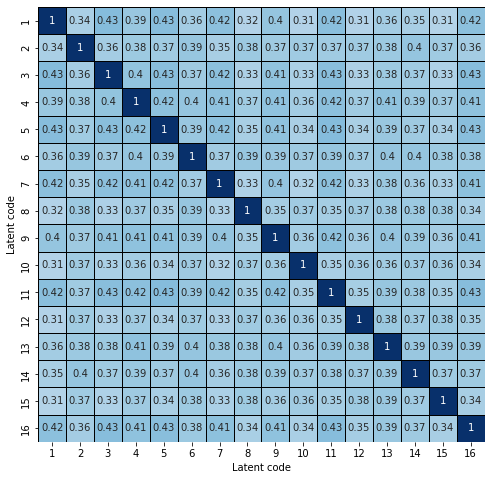

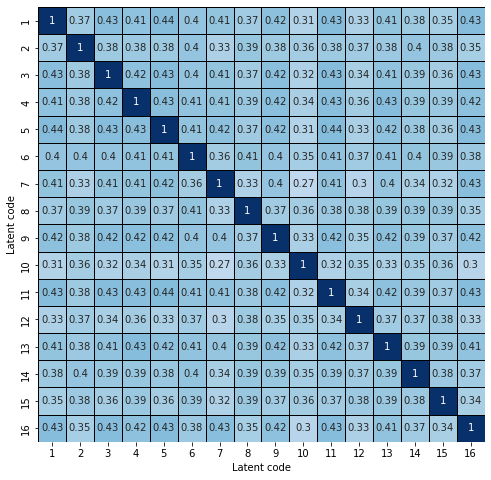

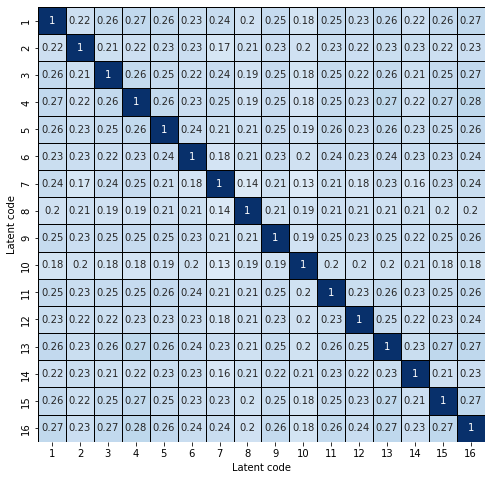

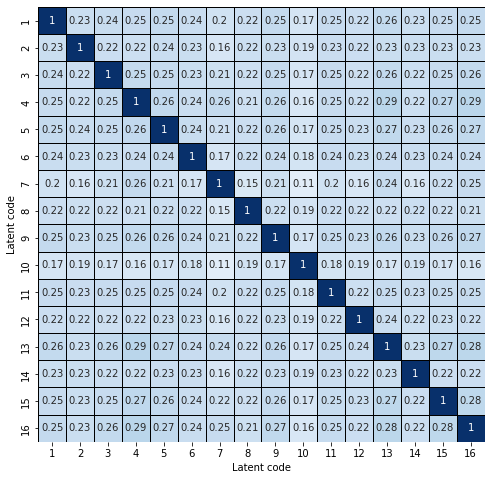

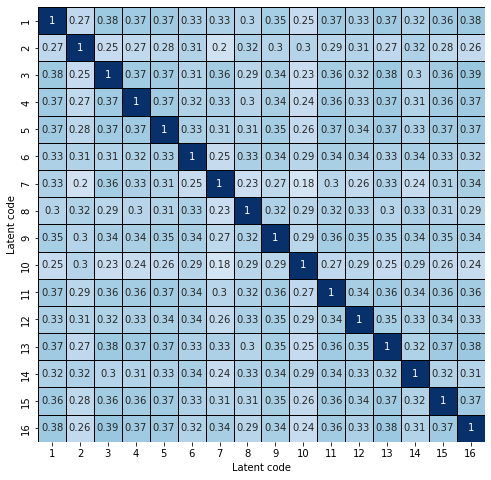

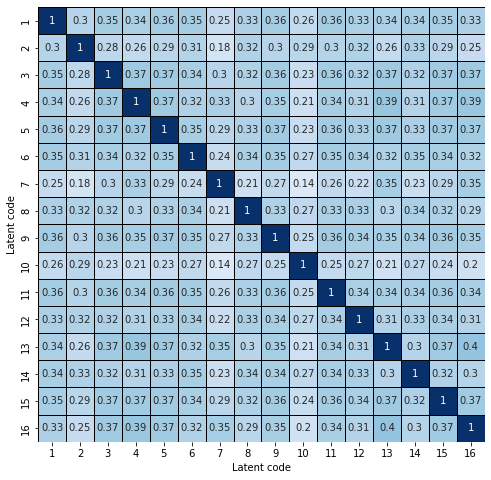

In [77]:
for corpus in ['Total', 'HOPE', 'Counselling and Psychotherapy Transcripts Volume II']:
    for model in MODELS:
        fig = plt.figure(figsize=(8, 8))
        sns.heatmap(latent_results[corpus][model]['test']['Posterior']['mat'], vmin=0., vmax=1., annot=True, xticklabels=[str(i + 1) for i in range(N_LATENTS)], yticklabels=[str(i + 1) for i in range(N_LATENTS)], cmap='Blues', cbar=False, linewidths=0.5, linecolor='black')
        plt.xlabel('Latent code')
        plt.ylabel('Latent code')
        plt.show()
        
        fig.savefig(f'test_jaccard_cm_{model.lower().replace("-", "_")}_{corpus.lower().replace(" ", "_")}.pdf', bbox_inches='tight')

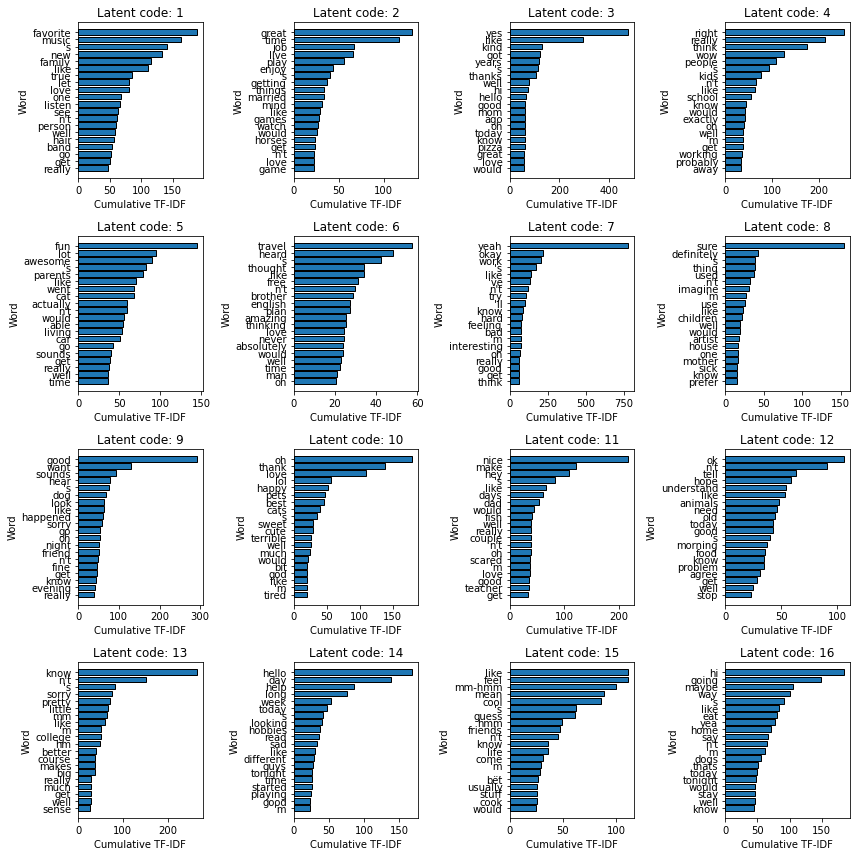

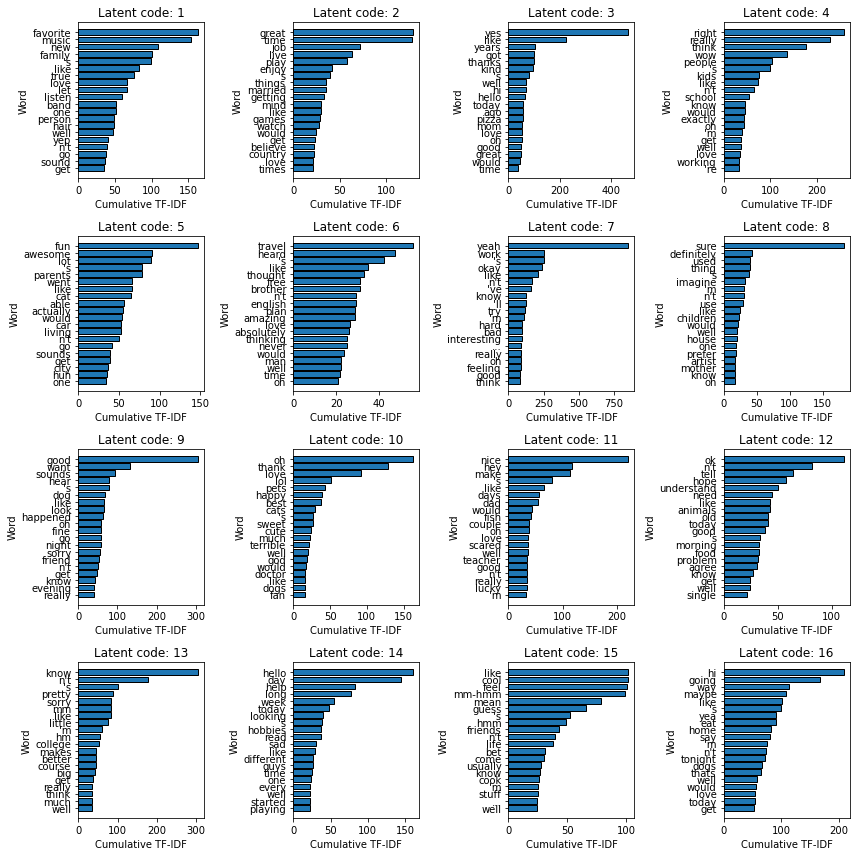

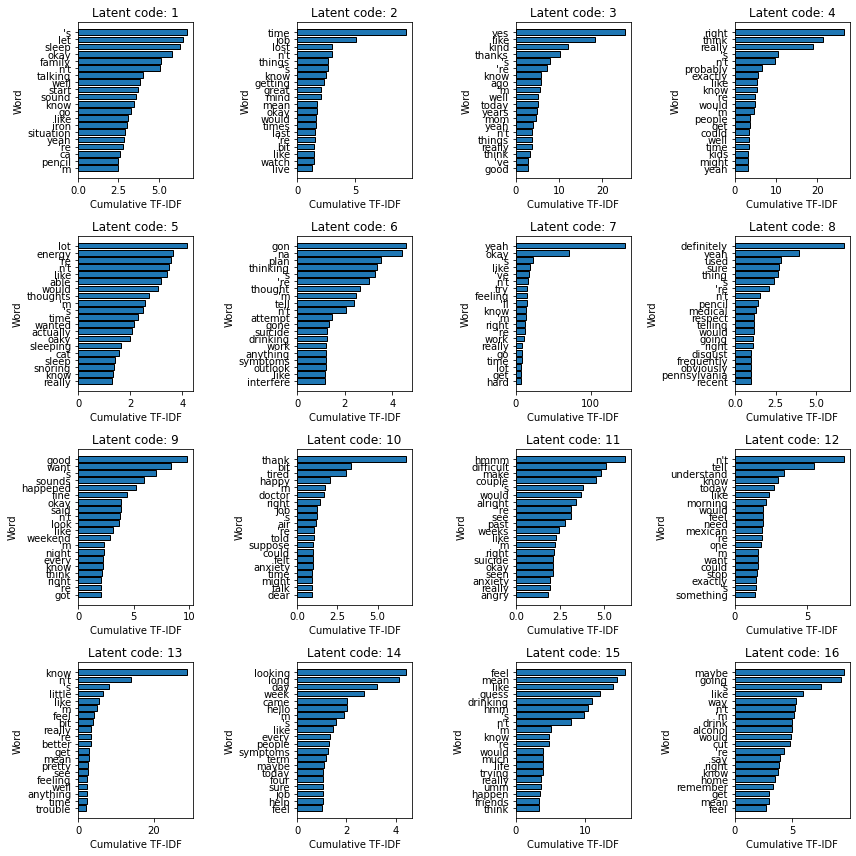

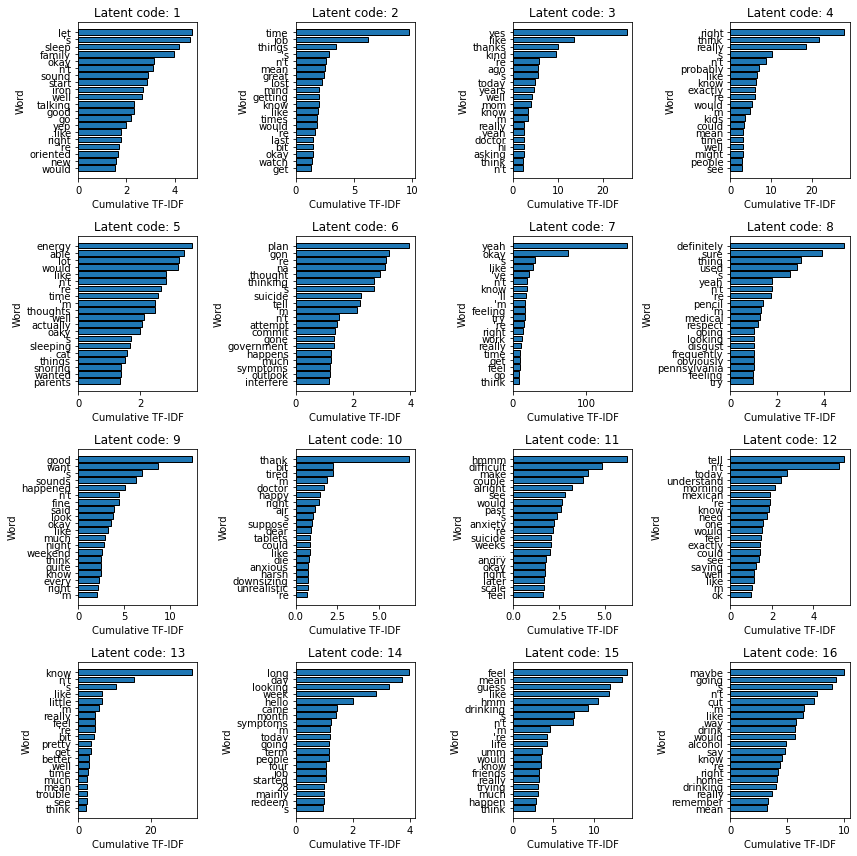

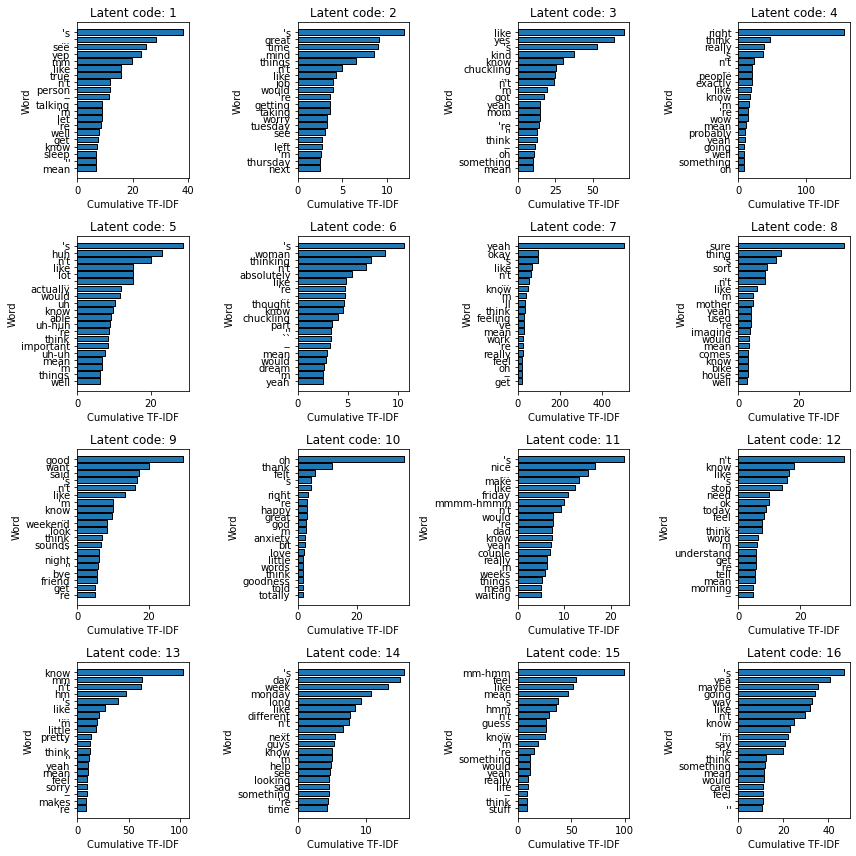

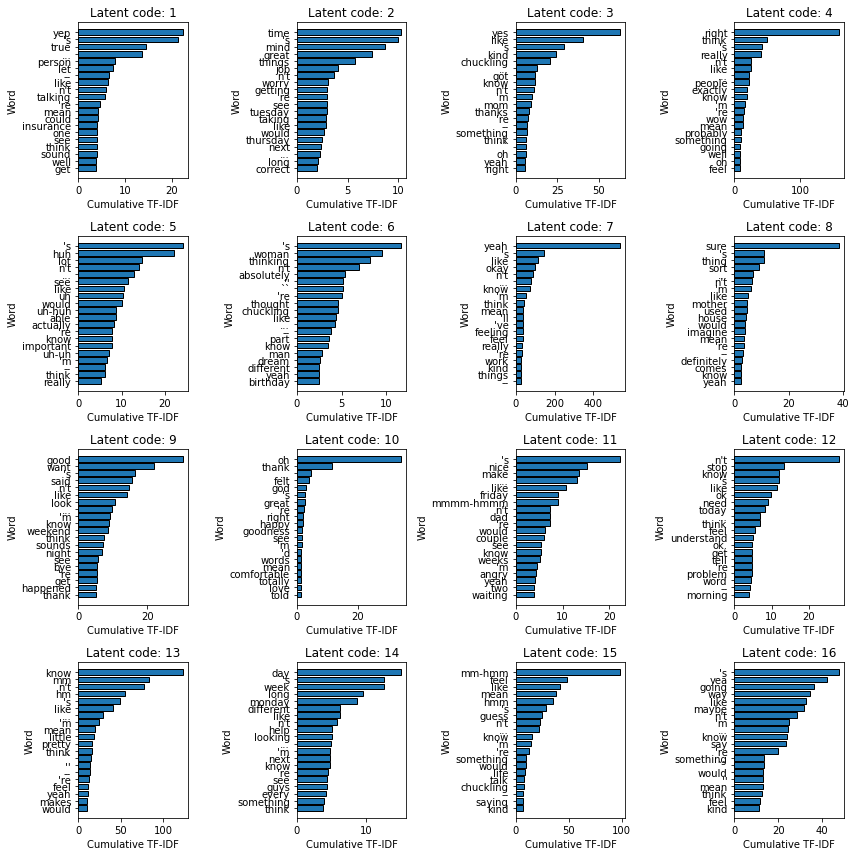

In [70]:
for corpus in ['Total', 'HOPE', 'Counselling and Psychotherapy Transcripts Volume II']:
    for model in MODELS:
        fig, axes = plt.subplots(nrows=int(math.ceil(N_LATENTS / (N_LATENTS // 4))), ncols=N_LATENTS // 4, figsize=(12, 12))
        z_idx = 0
        for i in range(int(math.ceil(N_LATENTS / (N_LATENTS // 4)))):
            for j in range(N_LATENTS // 4):
                x, y = [*zip(*latent_results[corpus][model]['test']['Posterior']['counts'][z_idx].most_common(TOP_WORDS))]
                axes[i][j].barh(x[::-1], y[::-1], linewidth=1., edgecolor='0')
                axes[i][j].set_title(f'Latent code: {z_idx + 1}')
                axes[i][j].set_xlabel('Cumulative TF-IDF')
                axes[i][j].set_ylabel('Word')
                z_idx += 1
        plt.tight_layout()
        plt.show()
    
        fig.savefig(f'test_top_words_{model.lower().replace("-", "_")}_{corpus.lower().replace(" ", "_")}.pdf', bbox_inches='tight')